In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, precision_score, mean_absolute_error, r2_score
from sklearn.metrics import roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
#import xgboost as xgb
#import shap
import matplotlib.pyplot as plt
from datetime import datetime



In [15]:

riders_data = pd.read_csv('riders.csv')
riders_rfm = pd.read_csv('riders_rfm.csv')
df = pd.merge(riders_rfm, riders_data[['user_id', 'churn_prob','age','loyalty_status','city']], on='user_id')

In [17]:
riders_data.head()

,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,NaN
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,NaN
3,R00003,2025-03-17,Bronze,41.658628,Nairobi,4.9,0.244779,NaN
4,R00004,2024-08-20,Silver,40.681709,Lagos,3.9,0.269960,R00002


In [19]:
riders_rfm.head()

,user_id,recency,frequency,monetary
0,R00000,48,25,366.05
1,R00001,28,14,180.53
2,R00002,37,24,378.99
3,R00003,84,9,121.47
4,R00004,35,16,268.43


In [21]:
df.head()

,user_id,recency,frequency,monetary,churn_prob,age,loyalty_status,city
0,R00000,48,25,366.05,0.142431,34.729629,Bronze,Nairobi
1,R00001,28,14,180.53,0.674161,34.571020,Bronze,Nairobi
2,R00002,37,24,378.99,0.510379,47.133960,Bronze,Lagos
3,R00003,84,9,121.47,0.244779,41.658628,Bronze,Nairobi
4,R00004,35,16,268.43,0.269960,40.681709,Silver,Lagos


In [23]:
# Create target column
df['churned'] = (df['churn_prob'] > 0.5).astype(int)
df = df.drop(columns=['churn_prob'])

target_column = 'churned'
X = df.drop(columns=[target_column, 'user_id'])
y = df[target_column]

df.head()

,user_id,recency,frequency,monetary,age,loyalty_status,city,churned
0,R00000,48,25,366.05,34.729629,Bronze,Nairobi,0
1,R00001,28,14,180.53,34.571020,Bronze,Nairobi,1
2,R00002,37,24,378.99,47.133960,Bronze,Lagos,1
3,R00003,84,9,121.47,41.658628,Bronze,Nairobi,0
4,R00004,35,16,268.43,40.681709,Silver,Lagos,0


In [25]:
categorical_columns = ['loyalty_status','city']
numerical_columns =['recency','frequency','monetary','age',]
            
#Build a pipeline for numerical features:
# Impute missing values using the median.
# Scale the features using StandardScaler.
numerical_pipeline = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="median")), 
        ("scaler",MinMaxScaler()),  
        ])
# Build a pipeline for categorical features:
# Impute missing values using the most frequent value.
# One-hot encode categorical features.
categorical_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("OneHotEncoder", OneHotEncoder())
            ])

# Combine both pipelines into a single ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipeline", numerical_pipeline, numerical_columns),
        ("cat_pipeline", categorical_pipeline, categorical_columns)
        ])


In [27]:
X_transformed = preprocessor.fit_transform(X)

## Retrieve column names generated by the OneHotEncoder for categorical features.
ohe = preprocessor.named_transformers_["cat_pipeline"].named_steps["OneHotEncoder"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_columns))

# Combine numeric columns with one-hot encoded categorical column names.
final_columns = numerical_columns + ohe_feature_names

# Construct a new DataFrame with the transformed features.
X_transformed_df = pd.DataFrame(X_transformed, columns=final_columns)


In [29]:
#Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed_df, y)


In [31]:
print(f"After SMOTE - Class 1: {sum(y_resampled == 1)}, Class 0: {sum(y_resampled == 0)}")

After SMOTE - Class 1: 8937, Class 0: 8937


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [35]:
y_train.head()

10031    1
6172     0
2190     0
10375    1
2514     0
Name: churned, dtype: int32

In [37]:
log_reg = LogisticRegression(random_state=42,max_iter=1000)
# Fit the model
log_reg.fit(X_train, y_train)
# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
    
# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")

AUC: 0.525
Precision: 0.510


In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [51]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
# Fit the model
random_forest.fit(X_train, y_train)
# Predictions
y_pred = random_forest.predict(X_test)
y_pred_proba = random_forest.predict_proba(X_test)[:, 1]
    
# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")


AUC: 0.968
Precision: 0.914


In [53]:
gradient_boosting = GradientBoostingClassifier(n_estimators=100)
# Fit the model
gradient_boosting.fit(X_train, y_train)
# Predictions
y_pred = gradient_boosting.predict(X_test)
y_pred_proba = gradient_boosting.predict_proba(X_test)[:, 1]
    
# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")

AUC: 0.916
Precision: 0.998


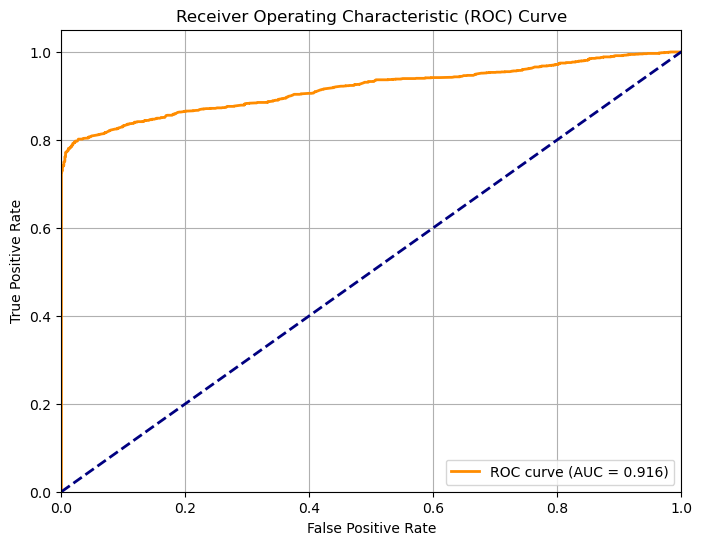

In [59]:
%matplotlib inline

# Ensure inline plotting
%matplotlib inline

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()

In [64]:
import joblib

# Save the model using joblib
joblib.dump(gradient_boosting,'models/churn_model.pkl')

print("Best XGBBoost model exported as 'churn_model.pkl'")


Best XGBBoost model exported as 'churn_model.pkl'


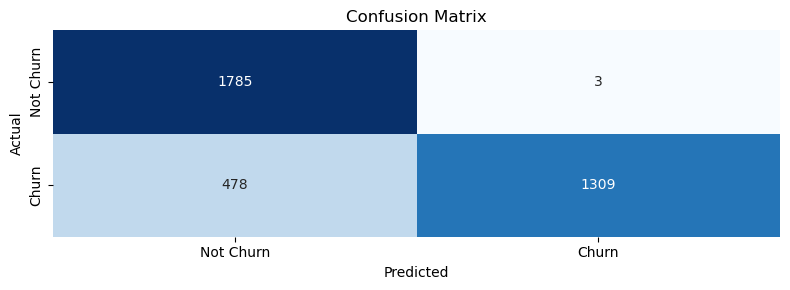

In [80]:
from sklearn.metrics import  confusion_matrix,classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

# Display the plot
plt.show()

In [88]:
import os

gradient_boosting = GradientBoostingClassifier(n_estimators=100)
# Fit the model
gradient_boosting.fit(X_train, y_train)
# Predictions
y_pred = gradient_boosting.predict(X_test)
y_pred_proba = gradient_boosting.predict_proba(X_test)[:, 1]
    
# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Create reports directory if it doesn't exist
os.makedirs('reports', exist_ok=True)

with open('reports/classification_report.txt', 'w') as f:
    f.write("Classification Report and Metrics\n")
    f.write("=" * 40 + "\n\n")
    f.write(f"AUC: {auc:.3f}\n")
    f.write(f"Precision: {precision:.3f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)

AUC: 0.916
Precision: 0.998
